In [ ]:
'''

This notebook does the following experiment - 
    1. Take a word as input
    2. Scrape its wiki page online
    3. Find first 3 word links(excluding the parent word) from the page
    4. Scrape the pages of those 3 words
    5. Repeat step 3
    6. End after a certain number of words have been encountered


'''

In [79]:
from bs4 import BeautifulSoup
import networkx as nx
import warnings
import requests
import re
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from collections import OrderedDict
import spacy
import numpy as np

In [80]:
model = spacy.load('en_core_web_sm')
model._path

WindowsPath('C:/Users/saura/anaconda3/lib/site-packages/en_core_web_sm/en_core_web_sm-3.0.0')

In [87]:
def check_url_text(url,text,tracker):
    
    text =  re.sub('[^a-zA-Z0-9\s]',' ',text).strip().lower()
    
    bad_words = ['jump to','help','wiki','wik','sister projects','free','online dictionary','references',
                 'log','sign','commons','redirect','news','newspaper','books','scholar','JSTOR','jstor','case sensitive',
                 'article','create','contributions','talk','main page','edit','contents','donate','contact us']
        
    if 'disambiguation' in text or 'verification' in text:
        return False
    
    elif len(text.split(' ')) > 2:
        return False
    
    elif 'cite' in url or 'citation' in url:
        return False
    
    elif len(text) == 0:
        return False
    
    elif text.isnumeric():
        return False
    
    elif any(w in text for w in bad_words) is True:
        return False

    elif text in tracker or text.lower() in tracker:
        return False
    
    else:
        return text

    
def check_similarity(root,current,threshold=0.5):
    try:
        root_vector = model(root).vector
    except:
        root_vector = np.zeros(96,)
    
    try:
        current_vector = model(current).vector
    except:
        current_vector = np.zeros(96,)
    
    try:
        cosine_similarity = np.dot(root_vector,current_vector)/(np.linalg.norm(root_vector)*np.linalg.norm(current_vector))
    
    except ZeroDivisionError:
        cosine_similarity = 0
    
    if cosine_similarity >  threshold:
        return True
    else:
        return False
    


def start_scraping(entry_word,nodes=3,skip=10,depth=10):
    
    
    if entry_word is None or len(entry_word) == 0:
        raise ValueError('Please enter a non empty string')
   
    result = OrderedDict()
    neighbors = []
    while len(result) != depth:
       
        base_url = f'https://en.wikipedia.org/wiki/{entry_word}'
        response = requests.get(base_url)
        soup = BeautifulSoup(response.content,'html.parser')

        links = soup.find_all('a',href=True)
        skip = 0 if skip >= len(links) else skip
        for link in links[skip:]:
            try:
                url = link['href']
                text = link.text
                res = check_url_text(url,text,result.keys())
                sim_check = check_similarity(entry_word,text)
                if res and sim_check:
                    neighbors.append(res)
            except:
                continue
            
            if len(neighbors) == nodes:
                break

        if len(neighbors) == 0:
            break
        result[entry_word] = neighbors.copy() # to prevent pop operation from affecting this
        entry_word = neighbors.pop(0)
        
    
    return result

In [88]:
result = start_scraping('computer',nodes=5,depth=15)

In [89]:
graph = nx.DiGraph(result)

In [90]:
graph.nodes()

NodeView(('computer', 'mainframe', 'desktop computer', 'supercomputer', 'summit', 'gamecube', 'memory', 'power supply', 'quadrillion', 'elevation', 'eu', 'human brain', 'frequency', 'ss', 'sea level', 'occipital lobes', 'neural tube', 'hertz', 'v', 'vertical datum'))

In [91]:
graph.edges()

OutEdgeView([('computer', 'mainframe'), ('computer', 'desktop computer'), ('computer', 'supercomputer'), ('computer', 'summit'), ('computer', 'gamecube'), ('mainframe', 'desktop computer'), ('mainframe', 'supercomputer'), ('mainframe', 'summit'), ('mainframe', 'gamecube'), ('mainframe', 'memory'), ('desktop computer', 'supercomputer'), ('desktop computer', 'summit'), ('desktop computer', 'gamecube'), ('desktop computer', 'memory'), ('desktop computer', 'power supply'), ('supercomputer', 'summit'), ('supercomputer', 'gamecube'), ('supercomputer', 'memory'), ('supercomputer', 'power supply'), ('supercomputer', 'quadrillion'), ('summit', 'gamecube'), ('summit', 'memory'), ('summit', 'power supply'), ('summit', 'quadrillion'), ('summit', 'elevation'), ('gamecube', 'memory'), ('gamecube', 'power supply'), ('gamecube', 'quadrillion'), ('gamecube', 'elevation'), ('gamecube', 'eu'), ('memory', 'power supply'), ('memory', 'quadrillion'), ('memory', 'elevation'), ('memory', 'eu'), ('memory', 'hu

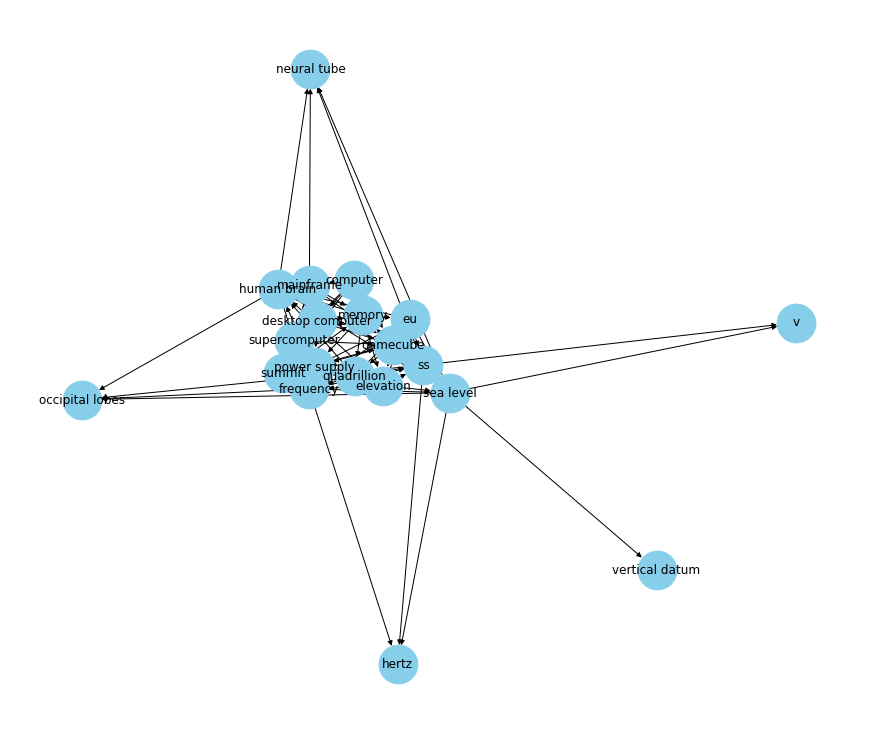

In [92]:
plt.figure(figsize=(12,10))
pos = nx.spring_layout(graph,k=0.5)
nx.draw(graph, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos,node_size=1500)
plt.show()